In [1]:
import os
import time
import datetime
import numpy as np
import cv2
import librosa

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchaudio
from torch.utils.data import DataLoader
import torchaudio.transforms as T

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython.display import Audio, display

import easydict

import network
import dataset
import utils
import wandb

In [2]:
margs_trainvalid = np.loadtxt('../split/margs_trainvalid.txt', delimiter=',', dtype=str)
margs_test = np.loadtxt('../split/margs_test.txt', delimiter=',', dtype=str)
nuss_trainvalid = np.loadtxt('../split/nuss_trainvalid.txt', delimiter=',', dtype=str)
nuss_test = np.loadtxt('../split/nuss_test.txt', delimiter=',', dtype=str)
vocals_trainvalid = np.loadtxt('../split/vocals_trainvalid.txt', delimiter=',', dtype=str)
vocals_test = np.loadtxt('../split/vocals_test.txt', delimiter=',', dtype=str)

margs_train, margs_valid = train_test_split(margs_trainvalid, test_size=0.1, shuffle=False, random_state=21)
nuss_train, nuss_valid = train_test_split(nuss_trainvalid, test_size=0.1, shuffle=False, random_state=21)
vocals_train, vocals_valid = train_test_split(vocals_trainvalid, test_size=0.1, shuffle=False, random_state=21)

# print(len(margs_trainvalid) + len(margs_test))
# print(len(nuss_trainvalid) + len(nuss_test))
# print(len(vocals_trainvalid) + len(vocals_test))

train_list = list(margs_train) + list(nuss_train) + list(vocals_train)
valid_list = list(margs_valid) + list(nuss_valid) + list(vocals_valid)
test_list = list(margs_test) + list(nuss_test) + list(vocals_test)
whole = train_list + valid_list + test_list
print('whole:', len(whole), 'train:', len(train_list), 'valid:', len(valid_list), 'test:', len(test_list))

whole: 9958 train: 7752 valid: 864 test: 1342


In [8]:
folder = '../dataset'
test_file, sr = torchaudio.load(os.path.join(folder, valid_list[0]))

In [4]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.amplitude_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_db_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(spec, origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)
    
def get_comlex_spectrogram(waveform, n_fft = 1024, win_len = 1024, hop_len = 512, power=None):
    spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_len,
    hop_length=hop_len,
    center=True,
    pad_mode="reflect",
    power=power,
    return_complex=0,
    )
    return spectrogram(waveform)

/opt/conda/lib/python3.7/site-packages/torchaudio/functional/functional.py:89: UserWarning: The use of pseudo complex type in spectrogram is now deprecated.Please migrate to native complex type by providing `return_complex=True`. Please refer to https://github.com/pytorch/audio/issues/1337 for more details about torchaudio's plan to migrate to native complex type.
  "The use of pseudo complex type in spectrogram is now deprecated."


torch.Size([1, 513, 431, 2])


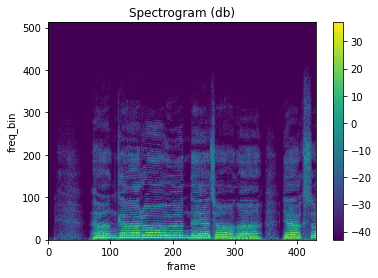

In [5]:
pad_data = test_file[:,:44100*5]
input_spec = get_comlex_spectrogram(pad_data)
print(input_spec.shape)
plot_spectrogram(input_spec[0][:,:,0])
play_audio(test_file[:,:44100*5], 44100)

/opt/conda/lib/python3.7/site-packages/torch/functional.py:546: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:817.)
  normalized, onesided, length, return_complex)


torch.Size([513, 431, 2])


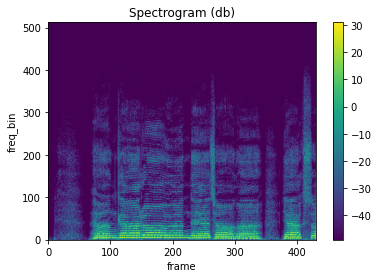

In [6]:
a_istft = torch.istft(input_spec[0], n_fft=1024, win_length=1024, hop_length=512)
a_istft.shape

a_istft_spec = get_comlex_spectrogram(a_istft)

print(a_istft_spec.shape)
plot_spectrogram(a_istft_spec[:,:,0].pow(1))
play_audio(a_istft.unsqueeze(0), 44100)

In [50]:
mask = np.load('../split/fixedmask_bbox/1.npy')

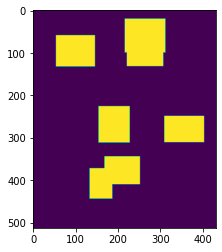

In [51]:
plt.imshow(mask[0])

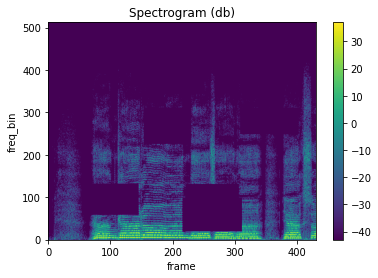

In [52]:
masked_real_spec = input_spec[0,:,:,0]*(1-mask[0])
masked_imag_spec = input_spec[0,:,:,1]*(1-mask[0])
comb = torch.cat((masked_real_spec.unsqueeze(-1), masked_imag_spec.unsqueeze(-1)), -1)
a_istft = torch.istft(comb, n_fft=1024, win_length=1024, hop_length=512)

masked_spec = input_spec[0,:,:,0]*(1-mask[0])
plot_spectrogram(masked_spec)
play_audio(a_istft.unsqueeze(0),44100)

In [76]:
masked_real_spec = input_spec[0,:,:,0]*(1-mask[0])
masked_imag_spec = input_spec[0,:,:,1]*(1-mask[0])
mask_real_result = real2[0]*mask[0]
mask_imag_result = real2[1]*mask[0]
recon_real = masked_real_spec + mask_real_result
recon_imag = masked_imag_spec + mask_imag_result
print(recon_real.shape, recon_imag.shape)

torch.Size([513, 431]) torch.Size([513, 431])


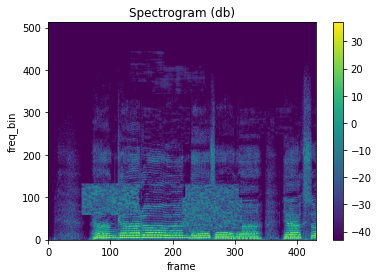

In [79]:
recon_comb = torch.cat((recon_real.unsqueeze(-1), recon_imag.unsqueeze(-1)), -1)
a_istft = torch.istft(recon_comb, n_fft=1024, win_length=1024, hop_length=512)

masked_spec = recon_imag[:,:]
plot_spectrogram(recon_real)
play_audio(a_istft.unsqueeze(0),44100)

In [72]:
real2.shape

(2, 513, 431)

In [53]:
perm_input = input_spec.permute(0, 3, 1, 2)
perm_mask = torch.from_numpy(mask).unsqueeze(0)
print(perm_input.shape, perm_mask.shape)

torch.Size([1, 2, 513, 431]) torch.Size([1, 1, 513, 431])


In [54]:
perm_input_cuda = perm_input.cuda()
mask_input_cuda = perm_mask.cuda()

In [28]:
import network

opt = easydict.EasyDict({
    "data_dir": '../dataset',
    "input_length": 220500,
    "image_height": 513,
    "image_width": 431,
    "bbox_shape": 120,
    "mask_type": 'bbox',
    "in_channels" : 3,
    "out_channels" : 2,
    "latent_channels" : 64,
    "pad_type": 'zero',
    "activation": 'lrelu',
    "norm":'in',
    "init_type":'xavier',
    "init_gain":0.02
    })

generator = network.GatedGenerator(opt)
generator = generator.cuda()

In [55]:
fake1, fake2 = generator(perm_input_cuda[:,:,:512,:428], mask_input_cuda[:,:,:512,:428])

In [56]:
fake1.shape, fake2.shape

(torch.Size([1, 2, 512, 428]), torch.Size([1, 2, 512, 428]))

In [57]:
real1 = np.zeros([2, 513, 431])
real2 = np.zeros([2, 513, 431])
fake1_cpu = fake1.detach().cpu().numpy()
fake2_cpu = fake2.detach().cpu().numpy()
print(fake1_cpu.shape, fake2_cpu.shape)

(1, 2, 512, 428) (1, 2, 512, 428)


In [58]:
real1[:,:512,:428] = fake1_cpu[0]
real2[:,:512,:428] = fake2_cpu[0]

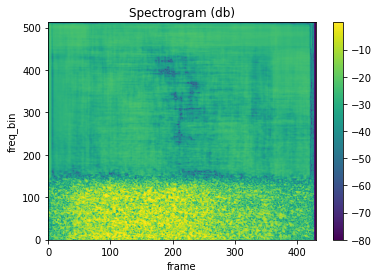

In [59]:
plot_spectrogram(real1[0])
real

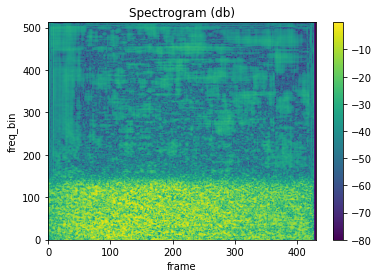

In [60]:
plot_spectrogram(real2[0])


In [62]:
real2.shape

(2, 513, 431)